In [3]:
import pandas as pd
import numpy as np
import os
from scipy.io import loadmat

In [336]:
# Load the CSV file
quality_df = pd.read_csv('Data_Quality_Evaluation.csv', index_col=0)

# Transpose the DataFrame
quality_df = quality_df.T


In [337]:
quality_df.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,2,1,1,4,1,5,3,5,1,5,...,5,1,1,5,3,4,1,1,5,1
2,1,4,5,1,1,5,1,1,1,1,...,3,1,1,3,1,1,1,2,1,2
3,1,1,1,1,1,1,1,1,3,1,...,1,4,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,5
5,5,5,4,3,3,4,4,4,5,4,...,4,3,4,3,3,3,3,3,5,4


In [338]:
# Define EEG channels
channels = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2"]

# Function to extract all channels from a .mat file
def get_all_channels_from_mat(file_path):
    """
    Load a .mat file and extract all channels as a NumPy array.
    Returns a 8xTime NumPy array where each row is a channel.
    Returns None if file doesn't exist or has issues.
    """
    try:
        mat_data = loadmat(file_path)
        
        # Use 'ThisEEG' as the data key
        data_key = 'ThisEEG'
        
        if data_key not in mat_data:
            print(f"Warning: 'ThisEEG' key not found in {file_path}")
            return None
        
        # Assume the data is already in 8xTime format
        data_array = mat_data[data_key]
        
        # Return as NumPy array with shape (8, time_points)
        return np.array(data_array, dtype=np.float64)
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


In [ ]:
# Step 1: Merge EEG and Personality DataFrames into one
# Merge on index (participant ID)
eeg_personality_merged_df = personality_filtered_1_to_36_df.merge(
    participant_mean_lzc_df_1_to_36,
    left_index=True,
    right_index=True,
    how='inner'
)

print(f"Merged DataFrame shape: {eeg_personality_merged_df.shape}")
eeg_personality_merged_df.head()


In [ ]:
# Step 2: Select only relevant columns (Personality + EEG channels)
# Extract personality trait columns and EEG LZC channel columns

personality_cols = [
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Emotional Stability",
    "Openness (Creativity)"
]

eeg_cols = channels  # delta, theta, alpha1, alpha2, beta1, beta2, gamma1, gamma2

# Create subset DataFrame with only relevant columns
eeg_personality_sub_df = eeg_personality_merged_df[personality_cols + eeg_cols].copy()

print(f"Subset DataFrame shape: {eeg_personality_sub_df.shape}")
eeg_personality_sub_df.head()


In [ ]:
# Step 3: Compute full Pearson correlation matrix (all variables)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Calculate correlation matrix for all personality and EEG variables
eeg_personality_corr_matrix = eeg_personality_sub_df.corr(method='pearson')

print("Full Correlation Matrix:")
print("=" * 80)
display(eeg_personality_corr_matrix)

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(eeg_personality_corr_matrix, annot=True, cmap="coolwarm", center=0, 
            fmt=".3f", square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Full Correlation Matrix: Personality Traits × EEG Channels", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [ ]:
# Step 4: Compute Personality × EEG correlation matrix only
# Smaller table with personality traits as rows and EEG channels as columns

# Calculate correlations: each personality trait with each EEG channel
eeg_personality_pair_corr = eeg_personality_sub_df[personality_cols].corrwith(
    eeg_personality_sub_df[eeg_cols], method='pearson', axis=0
)

# Convert to DataFrame with traits as rows and channels as columns
eeg_personality_pair_corr = pd.DataFrame(eeg_personality_pair_corr).T
eeg_personality_pair_corr.index = personality_cols
eeg_personality_pair_corr.columns = eeg_cols

print("Personality × EEG Correlation Matrix:")
print("=" * 80)
display(eeg_personality_pair_corr)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(eeg_personality_pair_corr, annot=True, cmap="coolwarm", center=0, 
            fmt=".3f", linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Personality Traits × EEG Channels Correlation Matrix", fontsize=14, pad=20)
plt.xlabel("EEG Channels", fontsize=12)
plt.ylabel("Personality Traits", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Step 5: Compute pairwise correlations with p-values
# For every combination of personality trait and EEG channel

results_list = []

for trait in personality_cols:
    for channel in eeg_cols:
        # Get valid pairs (drop NaN values)
        valid_data = eeg_personality_sub_df[[trait, channel]].dropna()
        
        if len(valid_data) > 2:  # Need at least 3 points for correlation
            # Pearson correlation with p-value
            r, p = stats.pearsonr(valid_data[trait], valid_data[channel])
            
            results_list.append({
                "Personality_Trait": trait,
                "EEG_Channel": channel,
                "Pearson_r": r,
                "p_value": p,
                "N": len(valid_data)
            })
        else:
            results_list.append({
                "Personality_Trait": trait,
                "EEG_Channel": channel,
                "Pearson_r": np.nan,
                "p_value": np.nan,
                "N": len(valid_data)
            })

# Create DataFrame with correlation statistics
eeg_personality_corrstats_df = pd.DataFrame(results_list)

print("Correlation Statistics:")
print("=" * 80)
display(eeg_personality_corrstats_df)


In [ ]:
# Step 6: Apply FDR correction (Benjamini-Hochberg)
from statsmodels.stats.multitest import multipletests

# Extract p-values (excluding NaN values)
p_values = eeg_personality_corrstats_df['p_value'].values
valid_mask = ~np.isnan(p_values)

# Apply FDR correction only to valid p-values
if np.any(valid_mask):
    p_fdr_corrected = np.full(len(p_values), np.nan)
    _, p_fdr_corrected[valid_mask], _, _ = multipletests(
        p_values[valid_mask], 
        alpha=0.05, 
        method='fdr_bh'
    )
    
    eeg_personality_corrstats_df['p_fdr'] = p_fdr_corrected
    eeg_personality_corrstats_df['significant_fdr'] = eeg_personality_corrstats_df['p_fdr'] < 0.05
else:
    eeg_personality_corrstats_df['p_fdr'] = np.nan
    eeg_personality_corrstats_df['significant_fdr'] = False

print("Correlation Statistics with FDR Correction:")
print("=" * 80)
display(eeg_personality_corrstats_df)

print(f"\nNumber of significant correlations (FDR < 0.05): {eeg_personality_corrstats_df['significant_fdr'].sum()}")


In [ ]:
# Step 7: Create heatmap of significant correlations only
# Create mask from significant_fdr values

# Reshape the significant_fdr column back into a matrix
sig_matrix = np.full((len(personality_cols), len(eeg_cols)), False)
sig_mask = np.full((len(personality_cols), len(eeg_cols)), True)  # Mask for non-significant

for idx, row in eeg_personality_corrstats_df.iterrows():
    trait_idx = personality_cols.index(row['Personality_Trait'])
    channel_idx = eeg_cols.index(row['EEG_Channel'])
    
    if row['significant_fdr']:
        sig_matrix[trait_idx, channel_idx] = True
        sig_mask[trait_idx, channel_idx] = False  # Don't mask significant ones
    else:
        sig_mask[trait_idx, channel_idx] = True  # Mask non-significant ones

# Create the correlation matrix with only significant values shown
eeg_personality_sig_matrix = eeg_personality_pair_corr.copy()
eeg_personality_sig_matrix = eeg_personality_sig_matrix.where(~sig_mask, np.nan)

print("Significant Correlations Only (FDR < 0.05):")
print("=" * 80)
display(eeg_personality_sig_matrix)

# Plot heatmap with mask
plt.figure(figsize=(12, 6))
sns.heatmap(eeg_personality_pair_corr, annot=True, cmap="coolwarm", center=0, 
            fmt=".3f", linewidths=0.5, cbar_kws={"shrink": 0.8},
            mask=sig_mask,  # Mask non-significant correlations
            annot_kws={"fontsize": 10})
plt.title("Significant Personality Traits × EEG Channels Correlations (FDR < 0.05)", 
          fontsize=14, pad=20)
plt.xlabel("EEG Channels", fontsize=12)
plt.ylabel("Personality Traits", fontsize=12)
plt.tight_layout()
plt.show()


In [339]:
# Build the main DataFrame
# Participants: 1 to 58 (as strings to match quality_df)
# Video clips: 1 to 36

participants = [str(i) for i in range(1, 59)]  # "1" to "58" as strings
video_clips = list(range(1, 37))  # 1 to 36

# Initialize DataFrame with object dtype to store NumPy arrays
eeg_df = pd.DataFrame(index=participants, columns=video_clips, dtype=object)

# Fill the DataFrame
for participant in participants:
    # Convert participant string to P01 format for folder name
    participant_folder = f"P{int(participant):02d}"
    
    for video_id in video_clips:
        file_path = f'EEGData/Movie_{participant_folder}/EEG_Clip{video_id}.mat'
        
        # Get all channels as a NumPy array (8xTime)
        eeg_array = get_all_channels_from_mat(file_path)
        
        if eeg_array is not None:
            eeg_df.at[participant, video_id] = eeg_array
        else:
            eeg_df.at[participant, video_id] = None
    
eeg_df.shape

(58, 36)

In [340]:
eeg_df.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,"[[336.0, 234.5, 133.0, 133.0, 133.0, 133.0, 13...","[[435.0, 435.0, 372.0, 309.0, 309.0, 357.0, 40...","[[325.0, 325.0, 328.5, 332.0, 332.0, 332.0, 35...","[[374.0, 374.0, 374.0, 413.5, 453.0, 453.0, 45...","[[264.0, 260.0, 256.0, 256.0, 307.0, 358.0, 35...","[[272.5, 268.0, 268.0, 290.0, 312.0, 312.0, 31...","[[345.5, 314.0, 314.0, 323.0, 332.0, 332.0, 34...","[[385.0, 385.0, 333.5, 282.0, 282.0, 326.5, 37...","[[289.0, 289.0, 281.5, 274.0, 274.0, 274.0, 27...","[[470.0, 470.0, 381.0, 292.0, 292.0, 355.0, 41...",...,"[[89.0, 89.0, 89.0, 89.0, 89.0, 89.0, 188.5, 2...","[[305.0, 306.5, 308.0, 308.0, 272.5, 237.0, 23...","[[320.5, 315.0, 315.0, 315.0, 303.5, 292.0, 29...","[[277.0, 278.0, 279.0, 289.0, 299.0, 299.0, 29...","[[528.0, 528.0, 404.0, 280.0, 280.0, 261.0, 24...","[[135.0, 135.0, 161.5, 188.0, 188.0, 218.0, 24...","[[401.0, 401.0, 369.0, 337.0, 337.0, 364.5, 39...","[[329.0, 329.0, 329.0, 329.0, 329.0, 354.0, 37...","[[213.0, 276.5, 340.0, 340.0, 365.0, 390.0, 39...","[[458.0, 458.0, 458.0, 369.5, 281.0, 281.0, 33..."
2,"[[410.0, 381.5, 353.0, 353.0, 318.5, 284.0, 28...","[[257.0, 257.0, 257.0, 257.0, 257.0, 318.0, 37...","[[259.0, 343.5, 428.0, 428.0, 398.5, 369.0, 36...","[[497.0, 337.0, 337.0, 337.0, 333.0, 329.0, 32...","[[389.0, 389.0, 389.0, 352.0, 315.0, 315.0, 27...","[[295.0, 295.0, 305.5, 316.0, 316.0, 324.0, 33...","[[170.5, 341.0, 341.0, 379.0, 417.0, 417.0, 41...","[[628.0, 628.0, 628.0, 628.0, 637.0, 646.0, 64...","[[603.0, 392.0, 181.0, 181.0, 208.5, 236.0, 23...","[[700.0, 700.0, 700.0, 0.0, 0.0, 0.0, 117.0, 1...",...,"[[120.0, 206.5, 293.0, 293.0, 293.0, 299.5, 30...","[[749.0, 749.0, 624.0, 499.0, 499.0, 476.5, 45...","[[88.0, 88.0, 223.0, 358.0, 358.0, 357.5, 357....","[[314.0, 314.0, 519.5, 725.0, 725.0, 401.5, 78...","[[342.0, 348.0, 354.0, 354.0, 340.0, 326.0, 32...","[[217.0, 217.0, 256.0, 295.0, 295.0, 295.0, 32...","[[240.0, 322.0, 322.0, 462.5, 603.0, 603.0, 30...","[[116.5, 194.0, 194.0, 173.5, 153.0, 153.0, 21...","[[626.0, 631.5, 637.0, 637.0, 637.0, 476.0, 31...","[[362.0, 362.0, 362.0, 362.0, 362.0, 362.0, 36..."
3,"[[338.0, 356.0, 374.0, 374.0, 331.0, 288.0, 28...","[[300.0, 300.0, 328.5, 357.0, 357.0, 357.0, 34...","[[376.0, 360.0, 360.0, 322.0, 284.0, 284.0, 22...","[[0.0, 0.0, 105.0, 210.0, 210.0, 349.0, 488.0,...","[[321.0, 321.0, 321.0, 321.0, 321.0, 309.5, 29...","[[132.0, 132.0, 150.0, 168.0, 168.0, 175.5, 18...","[[344.5, 361.0, 361.0, 350.0, 339.0, 339.0, 34...","[[327.5, 360.0, 360.0, 345.5, 331.0, 331.0, 32...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[358.0, 314.0, 314.0, 302.0, 290.0, 290.0, 30...",...,"[[254.0, 254.0, 263.0, 272.0, 272.0, 262.5, 25...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[315.0, 315.0, 314.5, 314.0, 314.0, 314.0, 29...","[[348.5, 348.0, 348.0, 331.5, 315.0, 315.0, 31...","[[465.0, 352.0, 352.0, 267.0, 182.0, 182.0, 18...","[[244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 24...","[[421.0, 366.0, 311.0, 311.0, 295.5, 280.0, 28...","[[292.0, 232.5, 173.0, 173.0, 284.5, 396.0, 39...","[[323.0, 323.0, 161.5, 0.0, 0.0, 0.0, 0.0, 0.0...","[[459.0, 459.0, 459.0, 459.0, 433.5, 408.0, 40..."
4,"[[419.0, 663.5, 908.0, 908.0, 908.0, 646.5, 38...","[[267.0, 343.5, 420.0, 420.0, 210.0, 0.0, 0.0,...","[[408.0, 376.0, 344.0, 344.0, 262.0, 180.0, 18...","[[333.0, 226.0, 226.0, 226.0, 303.5, 381.0, 38...","[[320.0, 320.0, 340.0, 360.0, 360.0, 679.5, 99...","[[456.0, 415.5, 375.0, 320.0, 265.0, 265.0, 26...","[[296.0, 296.0, 409.5, 523.0, 523.0, 523.0, 76...","[[357.0, 374.0, 374.0, 366.0, 358.0, 358.0, 42...","[[358.0, 528.0, 528.0, 528.0, 237.0, 237.0, 23...","[[182.0, 9.0, 9.0, 80.0, 151.0, 151.0, 304.5, ...",...,"[[150.0, 150.0, 125.0, 100.0, 100.0, 132.5, 16...","[[283.0, 283.0, 303.5, 324.0, 324.0, 362.0, 40...","[[352.0, 340.0, 328.0, 328.0, 385.5, 443.0, 44...","[[111.0, 111.0, 111.0, 164.0, 164.0, 164.0, 16...","[[421.0, 343.0, 265.0, 265.0, 410.5, 556.0, 55...","[[148.0, 148.0, 185

In [341]:
# Create cleaned DataFrame based on quality scores
# 1 = perfect, 2 = good, 3 = ok, 4 = problematic, 5 = bad, 6 = missing
# Remove all data with quality score => 3

# Start with a copy of eeg_df
eeg_cleaned_df = eeg_df.copy()

# Iterate through all participants and video clips
for participant in eeg_cleaned_df.index:
    for video_id in eeg_cleaned_df.columns:
        # Check if quality score exists and is > 3
        if participant in quality_df.index and video_id in quality_df.columns:
            quality_score = quality_df.loc[participant, video_id]
            if pd.notna(quality_score) and quality_score > 3:
                # Set the corresponding EEG data to None
                eeg_cleaned_df.at[participant, video_id] = None


print(f"Original non-null cells: {eeg_df.notna().sum().sum()}")
print(f"Cleaned non-null cells: {eeg_cleaned_df.notna().sum().sum()}")
print(f"Cells removed: {eeg_df.notna().sum().sum() - eeg_cleaned_df.notna().sum().sum()}")


Original non-null cells: 2088
Cleaned non-null cells: 1623
Cells removed: 465


In [342]:
eeg_cleaned_df.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,"[[336.0, 234.5, 133.0, 133.0, 133.0, 133.0, 13...","[[435.0, 435.0, 372.0, 309.0, 309.0, 357.0, 40...","[[325.0, 325.0, 328.5, 332.0, 332.0, 332.0, 35...",None,"[[264.0, 260.0, 256.0, 256.0, 307.0, 358.0, 35...",None,"[[345.5, 314.0, 314.0, 323.0, 332.0, 332.0, 34...",None,"[[289.0, 289.0, 281.5, 274.0, 274.0, 274.0, 27...",None,...,None,"[[305.0, 306.5, 308.0, 308.0, 272.5, 237.0, 23...","[[320.5, 315.0, 315.0, 315.0, 303.5, 292.0, 29...",None,"[[528.0, 528.0, 404.0, 280.0, 280.0, 261.0, 24...",None,"[[401.0, 401.0, 369.0, 337.0, 337.0, 364.5, 39...","[[329.0, 329.0, 329.0, 329.0, 329.0, 354.0, 37...",None,"[[458.0, 458.0, 458.0, 369.5, 281.0, 281.0, 33..."
2,"[[410.0, 381.5, 353.0, 353.0, 318.5, 284.0, 28...",None,None,"[[497.0, 337.0, 337.0, 337.0, 333.0, 329.0, 32...","[[389.0, 389.0, 389.0, 352.0, 315.0, 315.0, 27...",None,"[[170.5, 341.0, 341.0, 379.0, 417.0, 417.0, 41...","[[628.0, 628.0, 628.0, 628.0, 637.0, 646.0, 64...","[[603.0, 392.0, 181.0, 181.0, 208.5, 236.0, 23...","[[700.0, 700.0, 700.0, 0.0, 0.0, 0.0, 117.0, 1...",...,"[[120.0, 206.5, 293.0, 293.0, 293.0, 299.5, 30...","[[749.0, 749.0, 624.0, 499.0, 499.0, 476.5, 45...","[[88.0, 88.0, 223.0, 358.0, 358.0, 357.5, 357....","[[314.0, 314.0, 519.5, 725.0, 725.0, 401.5, 78...","[[342.0, 348.0, 354.0, 354.0, 340.0, 326.0, 32...","[[217.0, 217.0, 256.0, 295.0, 295.0, 295.0, 32...","[[240.0, 322.0, 322.0, 462.5, 603.0, 603.0, 30...","[[116.5, 194.0, 194.0, 173.5, 153.0, 153.0, 21...","[[626.0, 631.5, 637.0, 637.0, 637.0, 476.0, 31...","[[362.0, 362.0, 362.0, 362.0, 362.0, 362.0, 36..."
3,"[[338.0, 356.0, 374.0, 374.0, 331.0, 288.0, 28...","[[300.0, 300.0, 328.5, 357.0, 357.0, 357.0, 34...","[[376.0, 360.0, 360.0, 322.0, 284.0, 284.0, 22...","[[0.0, 0.0, 105.0, 210.0, 210.0, 349.0, 488.0,...","[[321.0, 321.0, 321.0, 321.0, 321.0, 309.5, 29...","[[132.0, 132.0, 150.0, 168.0, 168.0, 175.5, 18...","[[344.5, 361.0, 361.0, 350.0, 339.0, 339.0, 34...","[[327.5, 360.0, 360.0, 345.5, 331.0, 331.0, 32...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[358.0, 314.0, 314.0, 302.0, 290.0, 290.0, 30...",...,"[[254.0, 254.0, 263.0, 272.0, 272.0, 262.5, 25...",None,"[[315.0, 315.0, 314.5, 314.0, 314.0, 314.0, 29...","[[348.5, 348.0, 348.0, 331.5, 315.0, 315.0, 31...","[[465.0, 352.0, 352.0, 267.0, 182.0, 182.0, 18...","[[244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 24...","[[421.0, 366.0, 311.0, 311.0, 295.5, 280.0, 28...","[[292.0, 232.5, 173.0, 173.0, 284.5, 396.0, 39...","[[323.0, 323.0, 161.5, 0.0, 0.0, 0.0, 0.0, 0.0...","[[459.0, 459.0, 459.0, 459.0, 433.5, 408.0, 40..."
4,"[[419.0, 663.5, 908.0, 908.0, 908.0, 646.5, 38...","[[267.0, 343.5, 420.0, 420.0, 210.0, 0.0, 0.0,...","[[408.0, 376.0, 344.0, 344.0, 262.0, 180.0, 18...","[[333.0, 226.0, 226.0, 226.0, 303.5, 381.0, 38...","[[320.0, 320.0, 340.0, 360.0, 360.0, 679.5, 99...","[[456.0, 415.5, 375.0, 320.0, 265.0, 265.0, 26...","[[296.0, 296.0, 409.5, 523.0, 523.0, 523.0, 76...","[[357.0, 374.0, 374.0, 366.0, 358.0, 358.0, 42...","[[358.0, 528.0, 528.0, 528.0, 237.0, 237.0, 23...","[[182.0, 9.0, 9.0, 80.0, 151.0, 151.0, 304.5, ...",...,"[[150.0, 150.0, 125.0, 100.0, 100.0, 132.5, 16...","[[283.0, 283.0, 303.5, 324.0, 324.0, 362.0, 40...","[[352.0, 340.0, 328.0, 328.0, 385.5, 443.0, 44...","[[111.0, 111.0, 111.0, 164.0, 164.0, 164.0, 16...","[[421.0, 343.0, 265.0, 265.0, 410.5, 556.0, 55...","[[148.0, 148.0, 185.0, 185.0, 185.0, 213.0, 21...","[[374.0, 329.0, 284.0, 284.0, 340.0, 396.0, 39...","[[364.0, 364.0, 432.0, 432.0, 432.0, 456.0, 45...","[[312.0, 312.0, 319.5, 327.0, 327.0, 163.5, 0....",None
5,None,None,None,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[346.0, 333.5, 321.0, 321.0, 296.5, 272.0, 27...",None,None,None,None,None,...,None,"[[183.0, 183.0, 183.0, 276.0, 369.0, 369.0, 39...",None,"[[312.0, 312.0, 582.0, 582.0, 582.0, 410.0, 41...","[[354.0, 354.0, 354.0, 354.0, 354.0, 354.0, 35...","[[330.0, 317.5, 305.0, 305.0, 306.5, 308.0, 30...","[[

In [343]:
# Get the delta channel of participant 3, video 5
eeg_cleaned_df.loc['37'][2][channels.index('beta1')]

array([1067., 1067., 1067., ..., 1308., 1308., 1308.])

In [344]:
from antropy import lziv_complexity

def calculate_lzc(signal, hz=32, epoch_len_sec=2.0):
    """
    signal: array of shape (1, samples) or (samples,)
    hz: sampling rate
    epoch_len_sec: length of epoch to calculate LPZ over
    
    Returns: average Lempel-Ziv complexity across all epochs
    """
    # Ensure signal is 1D
    if len(signal.shape) == 2:
        signal = signal.flatten()
    
    n_samples = len(signal)
    epoch_samples = int(hz * epoch_len_sec)  # number of samples per epoch
    n_epochs = n_samples // epoch_samples  # number of complete epochs
    
    if n_epochs == 0:
        return np.nan
    
    lzc_vals = []
    
    # Calculate LPZ for each epoch
    for e in range(n_epochs):
        # Extract epoch
        start_idx = e * epoch_samples
        end_idx = start_idx + epoch_samples
        epoch = signal[start_idx:end_idx]
        
        # Z-score the epoch
        z_scored = (epoch - np.mean(epoch)) / (np.std(epoch) + 1e-9)
        
        # Binarize (threshold at 0)
        binarized = (z_scored > 0).astype(int)
        
        # Calculate Lempel-Ziv complexity
        lzc = lziv_complexity(binarized)
        lzc_vals.append(lzc)
    
    # Return average LPZ across all epochs
    return np.mean(lzc_vals)


In [345]:
# Calculate LZC for all cells in eeg_cleaned_df
# Create a new DataFrame with the same shape
lzc_df = pd.DataFrame(index=eeg_cleaned_df.index, columns=eeg_cleaned_df.columns, dtype=object)

# Iterate through all participants and video clips
for participant in eeg_cleaned_df.index:
    for video_id in eeg_cleaned_df.columns:
        eeg_data = eeg_cleaned_df.at[participant, video_id]
        
        # If the cell is None, keep it None
        if eeg_data is None:
            lzc_df.at[participant, video_id] = None
        else:
            # eeg_data is an 8xTime NumPy array
            # Calculate LZC for each of the 8 channels
            lzc_values = []
            
            for channel_idx in range(8):
                # Extract the channel data (one row from the 8xTime array)
                channel_signal = eeg_data[channel_idx, :]
                
                # Calculate LZC for this channel
                lzc = calculate_lzc(channel_signal, hz=32, epoch_len_sec=2.0)
                lzc_values.append(lzc)
            
            # Store as NumPy array (NaN values will be preserved)
            lzc_df.at[participant, video_id] = np.array(lzc_values, dtype=np.float64)

print(f"LZC DataFrame shape: {lzc_df.shape}")
print(f"Non-null cells: {lzc_df.notna().sum().sum()}")


LZC DataFrame shape: (58, 36)
Non-null cells: 1623


In [346]:
# Count the number of non-None cells for each participant
valid_trial_counts = lzc_df.notna().sum(axis=1)

valid_trial_counts_dict = valid_trial_counts.to_dict()
print(valid_trial_counts_dict)

participants_with_no_valid_trials = [participant for participant, count in valid_trial_counts_dict.items() if count == 0]
print("Participants with 0 valid trials:", participants_with_no_valid_trials)

participants_with_less_than_3_valid_trials = [participant for participant, count in valid_trial_counts_dict.items() if count < 3]
print("Participants with <3 valid trials:", participants_with_less_than_3_valid_trials)

{'1': 21, '2': 31, '3': 34, '4': 34, '5': 9, '6': 4, '7': 11, '8': 10, '9': 0, '10': 18, '11': 12, '12': 22, '13': 0, '14': 2, '15': 12, '16': 25, '17': 8, '18': 1, '19': 33, '20': 36, '21': 35, '22': 16, '23': 36, '24': 35, '25': 36, '26': 35, '27': 36, '28': 34, '29': 34, '30': 36, '31': 36, '32': 36, '33': 35, '34': 34, '35': 35, '36': 36, '37': 35, '38': 36, '39': 36, '40': 35, '41': 36, '42': 35, '43': 36, '44': 23, '45': 36, '46': 35, '47': 36, '48': 36, '49': 36, '50': 35, '51': 36, '52': 36, '53': 36, '54': 36, '55': 36, '56': 35, '57': 18, '58': 36}
Participants with 0 valid trials: ['9', '13']
Participants with <3 valid trials: ['9', '13', '14', '18']


In [347]:
# Filter out rows with participants with less than 3 valid trials
lzc_filtered_df = lzc_df[~lzc_df.index.isin(participants_with_less_than_3_valid_trials)]

In [348]:
lzc_filtered_df.shape

(54, 36)

In [349]:
lzc_filtered_df.loc['38']

1     [7.259803921568627, 2.1127450980392157, 2.1176...
2     [7.850746268656716, 2.1194029850746268, 2.1194...
3     [8.072727272727272, 2.109090909090909, 2.12727...
4     [8.105882352941176, 2.1058823529411765, 2.1058...
5     [8.651741293532337, 2.1044776119402986, 2.0945...
6     [7.403846153846154, 2.105769230769231, 2.10576...
7     [8.383333333333333, 2.1222222222222222, 2.1277...
8     [7.711111111111111, 2.1037037037037036, 2.1111...
9     [7.8, 2.1, 2.1142857142857143, 2.1142857142857...
10    [6.216666666666667, 2.1166666666666667, 2.1055...
11    [7.508333333333334, 2.1, 2.1, 2.10833333333333...
12    [7.333333333333333, 2.111111111111111, 2.11666...
13    [7.313725490196078, 2.1372549019607843, 2.1372...
14    [7.855769230769231, 2.105769230769231, 2.10576...
15    [7.852941176470588, 2.1176470588235294, 2.1078...
16    [8.612068965517242, 2.1120689655172415, 2.1034...
17    [7.15, 2.09375, 2.11875, 2.13125, 2.13125, 2.1...
18    [7.805194805194805, 2.116883116883117, 2.0

In [350]:
lzc_filtered_df

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,"[8.0, 3.0588235294117645, 3.1176470588235294, ...","[8.363636363636363, 2.878787878787879, 2.84848...","[8.666666666666666, 3.4444444444444446, 3.2592...",None,"[8.9, 3.32, 3.22, 2.8, 2.62, 3.34, 3.14, 3.16]",None,"[7.177777777777778, 2.2, 2.2444444444444445, 2...",None,"[8.571428571428571, 3.2285714285714286, 3.3142...",None,...,None,"[8.295454545454545, 3.3863636363636362, 3.4545...","[8.186046511627907, 2.883720930232558, 2.67441...",None,"[7.140625, 2.84375, 2.828125, 2.828125, 2.8281...",None,"[8.793103448275861, 3.3275862068965516, 3.4655...","[8.6, 3.1333333333333333, 3.2333333333333334, ...",None,"[8.35483870967742, 3.0, 3.032258064516129, 3.0..."
2,"[8.176470588235293, 3.235294117647059, 3.21568...",None,None,"[8.261904761904763, 3.1666666666666665, 3.3333...","[8.46, 3.18, 3.24, 3.06, 3.08, 3.02, 3.02, 3.06]",None,"[8.355555555555556, 3.4, 3.2666666666666666, 2...","[8.242424242424242, 3.1818181818181817, 3.0909...","[8.714285714285714, 3.2, 3.1142857142857143, 3...","[8.222222222222221, 3.0444444444444443, 3.1777...",...,"[8.17142857142857, 3.0285714285714285, 3.14285...","[8.318181818181818, 3.1363636363636362, 3.2727...","[8.767441860465116, 3.3255813953488373, 3.2790...","[8.256410256410257, 2.8461538461538463, 2.6923...","[8.640625, 3.171875, 3.265625, 3.21875, 3.1406...","[8.185185185185185, 3.1481481481481484, 3.1481...","[8.551724137931034, 3.3448275862068964, 3.2758...","[7.9, 3.0, 2.9, 3.066666666666667, 3.033333333...","[8.444444444444445, 3.1555555555555554, 3.2, 3...","[8.387096774193548, 3.161290322580645, 3.29032..."
3,"[8.509803921568627, 3.176470588235294, 3.29411...","[8.606060606060606, 3.121212121212121, 3.30303...","[8.814814814814815, 3.3333333333333335, 3.1481...","[7.857142857142857, 3.261904761904762, 3.33333...","[7.12, 3.28, 3.16, 3.08, 3.18, 3.16, 3.18, 3.08]","[7.0, 3.423076923076923, 3.3076923076923075, 3...","[7.2, 3.2888888888888888, 3.3333333333333335, ...","[8.181818181818182, 3.272727272727273, 3.36363...","[7.085714285714285, 3.085714285714286, 3.14285...","[8.11111111111111, 3.2444444444444445, 3.15555...",...,"[8.6, 3.3142857142857145, 3.2285714285714286, ...",None,"[7.744186046511628, 3.186046511627907, 3.34883...","[8.564102564102564, 3.1538461538461537, 3.3589...","[8.234375, 3.265625, 3.390625, 3.21875, 3.2031...","[8.11111111111111, 3.259259259259259, 3.148148...","[8.53448275862069, 3.2758620689655173, 3.29310...","[8.466666666666667, 3.2333333333333334, 3.4, 3...","[7.688888888888889, 3.022222222222222, 3.15555...","[7.645161290322581, 3.129032258064516, 3.06451..."
4,"[7.8431372549019605, 3.2941176470588234, 3.254...","[8.242424242424242, 3.212121212121212, 3.12121...","[7.962962962962963, 3.4074074074074074, 3.2592...","[7.738095238095238, 3.119047619047619, 3.16666...","[7.46, 3.36, 3.22, 3.18, 3.22, 3.12, 3.2, 3.06]","[7.8076923076923075, 3.076923076923077, 3.1923...","[7.111111111111111, 3.066666666666667, 3.02222...","[7.878787878787879, 3.272727272727273, 3.42424...","[7.942857142857143, 3.2857142857142856, 3.1142...","[8.177777777777777, 3.2444444444444445, 3.2888...",...,"[8.0, 2.6285714285714286, 3.342857142857143, 2...","[8.204545454545455, 3.2954545454545454, 3.4318...","[7.744186046511628, 3.395348837209302, 3.37209...","[8.076923076923077, 3.3846153846153846, 3.4358...","[7.890625, 2.6875, 2.609375, 2.96875, 2.921875...","[8.25925925925926, 3.2962962962962963, 3.37037...","[7.224137931034483, 2.7758620689655173, 2.7413...","[7.233333333333333, 3.3, 3.1666666666666665, 3...","[8.28888888888889, 3.2, 3.2888888888888888, 2....",None
5,None,None,None,"[5.9523809523809526, 3.1666666666666665, 3.238...","[5.88, 2.28, 2.26, 2.24, 2.28, 2.28, 2.18, 2.32]",None,None,None,None,None,...,None,"[7.681818181818182, 2.909090909090909, 2.86363...",None,"[8.0, 2.923076923076923, 2.8205128205128207, 2...","[7.140625, 2.890625, 2.84375, 2.9375, 2.84375,...","[8.407407407407407, 2.814814814814815, 2.75925...","[8.5, 3.05

In [351]:
# Calculate statistics for LZC scores by channel
# Collect all LZC values for each channel
channel_lzc_data = {channel: [] for channel in channels}

# Iterate through all cells in lzc_df
for participant in lzc_filtered_df.index:
    for video_id in lzc_filtered_df.columns:
        lzc_array = lzc_filtered_df.at[participant, video_id]
        
        # Skip None cells
        if lzc_array is not None:
            # lzc_array is a NumPy array of 8 values (one per channel)
            for channel_idx, channel_name in enumerate(channels):
                lzc_value = lzc_array[channel_idx]
                # Only add if not NaN
                if not np.isnan(lzc_value):
                    channel_lzc_data[channel_name].append(lzc_value)

# Calculate statistics for each channel
lzc_stats = []
for channel in channels:
    values = channel_lzc_data[channel]
    if len(values) > 0:
        stats = {
            'Channel': channel,
            'Count': len(values),
            'Mean': np.mean(values),
            'Std': np.std(values),
            'Min': np.min(values),
            'Max': np.max(values),
            'Median': np.median(values),
            '25th Percentile': np.percentile(values, 25),
            '75th Percentile': np.percentile(values, 75)
        }
    else:
        stats = {
            'Channel': channel,
            'Count': 0,
            'Mean': np.nan,
            'Std': np.nan,
            'Min': np.nan,
            'Max': np.nan,
            'Median': np.nan,
            '25th Percentile': np.nan,
            '75th Percentile': np.nan
        }
    lzc_stats.append(stats)

# Create DataFrame with statistics
lzc_stats_df = pd.DataFrame(lzc_stats)
lzc_stats_df


,Channel,Count,Mean,Std,Min,Max,Median,25th Percentile,75th Percentile
0,delta,1620,8.190599,0.706108,2.0,10.041667,8.325291,7.877489,8.622917
1,theta,1620,2.647780,0.586203,2.0,3.680000,2.128205,2.105882,3.259444
2,alpha1,1620,2.702249,0.583326,2.0,3.680000,2.900000,2.109091,3.279070
3,alpha2,1620,2.650604,0.518453,2.0,3.529412,2.824265,2.118164,3.151515
4,beta1,1620,2.649133,0.523065,2.0,3.705882,2.781046,2.117647,3.155556
5,beta2,1620,2.601717,0.475439,2.0,3.537037,2.726136,2.118110,3.066667
6,gamma1,1620,2.646517,0.519790,2.0,3.515152,2.882251,2.117647,3.152098
7,gamma2,1620,2.640119,0.498344,2.0,3.676471,2.960000,2.118182,3.111111


In [352]:
# Create a boolean matrix indicating if cells contain NaN values (but are not None)
# True if: cell is not None AND contains any NaN in any channel
# False if: cell is None OR (cell is not None AND has no NaN values)
# this is for testing, ignore

nan_or_none_df = pd.DataFrame(index=eeg_cleaned_df.index, columns=eeg_cleaned_df.columns, dtype=bool)

# Iterate through all participants and video clips
for participant in eeg_cleaned_df.index:
    for video_id in eeg_cleaned_df.columns:
        eeg_data = eeg_cleaned_df.at[participant, video_id]
        
        # If the cell is None, mark as False
        if eeg_data is None:
            nan_or_none_df.at[participant, video_id] = False
        else:
            # Check if there are any NaN values in the 8xTime array
            has_nan = np.any(np.isnan(eeg_data))
            nan_or_none_df.at[participant, video_id] = has_nan

print(f"Shape: {nan_or_none_df.shape}")
print(f"True values (not None but contains NaN): {nan_or_none_df.sum().sum()}")
print(f"False values (None or valid data with no NaN): {(~nan_or_none_df).sum().sum()}")
nan_or_none_df


Shape: (58, 36)
True values (not None but contains NaN): 959
False values (None or valid data with no NaN): 1129


,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False
5,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,True,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
8,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [353]:
# Find all participants/videos where nan_or_none_df is True AND quality_df is 2
# These are cases where the data has NaN values but was marked as "good" quality
# this is for testing, ignore

matching_cells = []

for participant in nan_or_none_df.index:
    for video_id in nan_or_none_df.columns:
        # Check if nan_or_none_df is True
        if nan_or_none_df.at[participant, video_id]:
            # Check if quality_df has value 2 for this participant/video
            if participant in quality_df.index and video_id in quality_df.columns:
                quality_score = quality_df.loc[participant, video_id]
                if pd.notna(quality_score) and quality_score == 2:
                    matching_cells.append({
                        'Participant': participant,
                        'Video': video_id,
                        'Quality Score': quality_score
                    })

# Create DataFrame from the matching cells
if matching_cells:
    matching_df = pd.DataFrame(matching_cells)
    print(f"Found {len(matching_cells)} cases where nan_or_none_df is True and quality_df is 2:")
    print()
else:
    print("No cases found where nan_or_none_df is True and quality_df is 2")
    matching_df = pd.DataFrame(columns=['Participant', 'Video', 'Quality Score'])

# Display the DataFrame
matching_df


Found 160 cases where nan_or_none_df is True and quality_df is 2:



,Participant,Video,Quality Score
0,16,3,2
1,16,12,2
2,16,21,2
3,16,23,2
4,16,24,2
...,...,...,...
155,58,30,2
156,58,31,2
157,58,33,2
158,58,35,2


In [354]:
lzc_df.loc['25'][20]

array([8.83333333, 3.3       , 3.3       , 3.13333333, 3.13333333,
       2.8       , 3.1       , 3.03333333])

In [355]:
# Correlation analysis between Gamma LZC scores and personality traits
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Merge the two DataFrames on participant index
merged_gamma_df = personality_filtered_1_to_36_df.merge(
    participant_gamma_mean_df,
    left_index=True,
    right_index=True,
    how='inner'
)

# --------------------------
# 1. Select variables
# --------------------------
traits = [
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Emotional Stability",
    "Openness (Creativity)"
]
entropy_col = "Mean_LZC_Gamma"

results_gamma = []

# --------------------------
# 2. Compute correlations
# --------------------------
for trait in traits:
    # Get valid pairs (drop NaN values)
    valid_data = merged_gamma_df[[trait, entropy_col]].dropna()
    
    if len(valid_data) > 2:  # Need at least 3 points for correlation
        # Pearson
        r, p = stats.pearsonr(valid_data[trait], valid_data[entropy_col])
        # Spearman
        rho, p_rho = stats.spearmanr(valid_data[trait], valid_data[entropy_col])
        
        results_gamma.append({
            "Trait": trait,
            "Pearson r": r,
            "Pearson p-value": p,
            "Spearman rho": rho,
            "Spearman p-value": p_rho,
            "N": len(valid_data)
        })
    else:
        results_gamma.append({
            "Trait": trait,
            "Pearson r": np.nan,
            "Pearson p-value": np.nan,
            "Spearman rho": np.nan,
            "Spearman p-value": np.nan,
            "N": len(valid_data)
        })

corr_gamma_df = pd.DataFrame(results_gamma)

# --------------------------
# 3. Show results
# --------------------------
print("Correlation Results (Gamma Only):")
print("=" * 80)
corr_gamma_df


Correlation Results (Gamma Only):


,Trait,Pearson r,Pearson p-value,Spearman rho,Spearman p-value,N
0,Extroversion,-0.069539,0.705298,-0.134704,0.462314,32
1,Agreeableness,-0.075520,0.681222,-0.125564,0.493500,32
2,Conscientiousness,-0.000494,0.997859,0.096706,0.598524,32
3,Emotional Stability,0.056571,0.758443,0.161255,0.377943,32
4,Openness (Creativity),-0.235644,0.194170,-0.360395,0.042738,32


In [ ]:
# Create DataFrame with participants as rows and channels as columns
# Each cell contains the mean LZC value for that participant-channel combination
# averaged across all non-None videos

# Initialize DataFrame with participants from lzc_filtered_df and channels as columns
participant_mean_lzc_df = pd.DataFrame(
    index=lzc_filtered_df.index,
    columns=channels,
    dtype=float
)

# For each participant, collect LZC values for each channel across all videos
for participant in lzc_filtered_df.index:
    for channel_idx, channel_name in enumerate(channels):
        # Collect all LZC values for this participant and channel
        lzc_values = []
        
        for video_id in lzc_filtered_df.columns:
            lzc_array = lzc_filtered_df.at[participant, video_id]
            
            # Skip None cells
            if lzc_array is not None:
                lzc_value = lzc_array[channel_idx]
                # Only add if not NaN
                if not np.isnan(lzc_value):
                    lzc_values.append(lzc_value)
        
        # Calculate mean if we have values, otherwise set to NaN
        if len(lzc_values) > 0:
            participant_mean_lzc_df.at[participant, channel_name] = np.mean(lzc_values)
        else:
            participant_mean_lzc_df.at[participant, channel_name] = np.nan

participant_mean_lzc_df


,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2
1,8.294353,3.059360,3.042115,3.032437,3.050291,3.020558,3.044040,3.031411
2,8.276642,3.124945,3.168349,3.056229,3.068867,3.013155,3.108805,3.118180
3,8.011520,3.233364,3.234732,3.165413,3.164423,3.045352,3.179710,3.148939
4,7.809252,3.181674,3.227305,3.139106,3.125650,3.135397,3.149707,3.112407
5,7.434075,2.875605,2.848425,2.889227,2.857680,2.820703,2.922773,2.921347
6,7.235566,2.665344,2.689426,2.804427,2.000000,2.760387,2.000000,2.774899
7,8.255093,2.967559,2.978760,2.850816,3.030078,2.894845,2.925311,2.965194
8,8.091651,3.191324,3.188345,2.986765,3.036135,3.104512,3.087578,3.047605
10,8.200836,3.106982,3.125568,3.127073,3.162925,3.056578,3.195773,3.111749
11,8.166004,2.968934,2.939399,2.887237,2.768522,2.821710,2.774203,2.963390


In [357]:
# Correlation analysis between LZC scores and personality traits
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Merge the two DataFrames on participant index
merged_df = personality_filtered_1_to_36_df.merge(
    participant_beta_gamma_mean_df,
    left_index=True,
    right_index=True,
    how='inner'
)

# --------------------------
# 1. Select variables
# --------------------------
traits = [
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Emotional Stability",
    "Openness (Creativity)"
]
entropy_col = "Mean_LZC_Beta_Gamma"

results = []

# --------------------------
# 2. Compute correlations
# --------------------------
for trait in traits:
    # Get valid pairs (drop NaN values)
    valid_data = merged_df[[trait, entropy_col]].dropna()
    
    if len(valid_data) > 2:  # Need at least 3 points for correlation
        # Pearson
        r, p = stats.pearsonr(valid_data[trait], valid_data[entropy_col])
        # Spearman
        rho, p_rho = stats.spearmanr(valid_data[trait], valid_data[entropy_col])
        
        results.append({
            "Trait": trait,
            "Pearson r": r,
            "Pearson p-value": p,
            "Spearman rho": rho,
            "Spearman p-value": p_rho,
            "N": len(valid_data)
        })
    else:
        results.append({
            "Trait": trait,
            "Pearson r": np.nan,
            "Pearson p-value": np.nan,
            "Spearman rho": np.nan,
            "Spearman p-value": np.nan,
            "N": len(valid_data)
        })

corr_df = pd.DataFrame(results)

# --------------------------
# 3. Show results
# --------------------------
print("Correlation Results:")
print("=" * 80)
corr_df


Correlation Results:


,Trait,Pearson r,Pearson p-value,Spearman rho,Spearman p-value,N
0,Extroversion,-0.045397,0.805128,-0.084236,0.646689,32
1,Agreeableness,-0.091628,0.617953,-0.197997,0.277356,32
2,Conscientiousness,-0.018475,0.920057,0.044408,0.809297,32
3,Emotional Stability,0.017339,0.924959,0.077784,0.672187,32
4,Openness (Creativity),-0.170678,0.350323,-0.255954,0.157371,32


Correlation Matrix:


,Extroversion,Agreeableness,Conscientiousness,Emotional Stability,Openness (Creativity),Mean_LZC_Beta_Gamma
Extroversion,1.000000,0.557771,0.204181,0.077285,0.614873,-0.045397
Agreeableness,0.557771,1.000000,0.108796,0.341494,0.371731,-0.091628
Conscientiousness,0.204181,0.108796,1.000000,0.243483,0.230033,-0.018475
Emotional Stability,0.077285,0.341494,0.243483,1.000000,-0.110795,0.017339
Openness (Creativity),0.614873,0.371731,0.230033,-0.110795,1.000000,-0.170678
Mean_LZC_Beta_Gamma,-0.045397,-0.091628,-0.018475,0.017339,-0.170678,1.000000


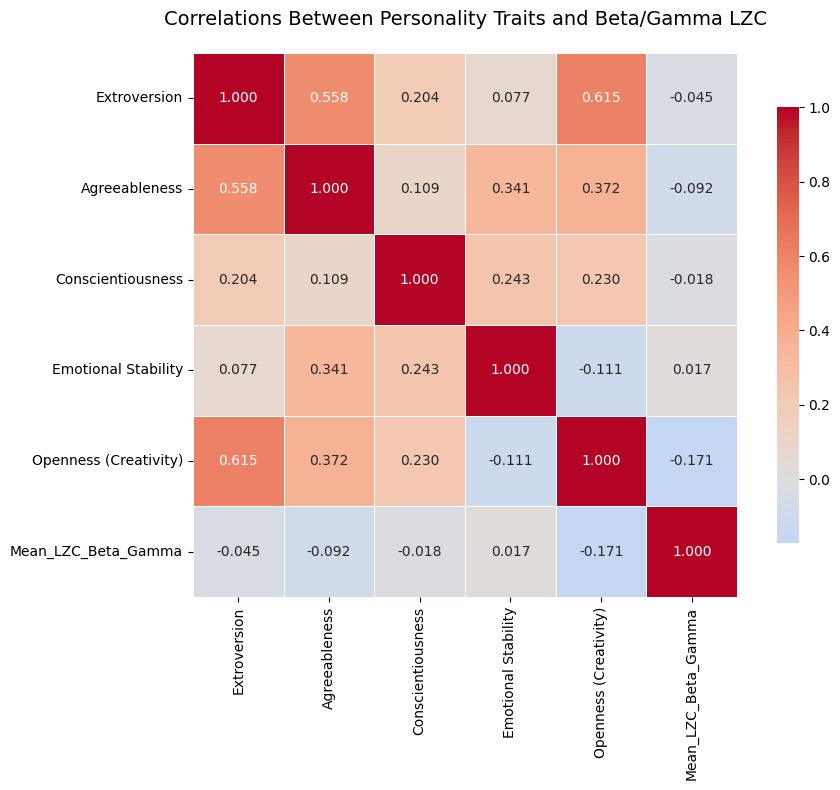

In [358]:
# --------------------------
# 4. Correlation matrix heatmap visualization
# --------------------------

# Select only personality traits + LZC for correlation matrix
cols = [
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Emotional Stability",
    "Openness (Creativity)",
    "Mean_LZC_Beta_Gamma"
]

trait_df = merged_df[cols]

# Compute correlation matrix using Pearson correlation
corr_matrix = trait_df.corr(method="pearson")

print("Correlation Matrix:")
print("=" * 80)
display(corr_matrix)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".3f", 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlations Between Personality Traits and Beta/Gamma LZC", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [359]:
# Create a new table with participants 1-36 and their mean LZC
# Average of beta1, beta2, gamma1, and gamma2

# Filter to participants 1-36 (as strings)
participants_1_to_36 = [str(i) for i in range(1, 37)]

# Filter participant_mean_lzc_df to only include participants 1-36
filtered_participants = participant_mean_lzc_df.index.intersection(participants_1_to_36)
participant_mean_lzc_subset = participant_mean_lzc_df.loc[filtered_participants]

# Calculate mean of beta1, beta2, gamma1, and gamma2 for each participant
beta_gamma_channels = ['beta1', 'beta2', 'gamma1', 'gamma2']
participant_beta_gamma_mean = participant_mean_lzc_subset[beta_gamma_channels].mean(axis=1)

# Create a DataFrame with participants as rows and the mean LZC as a column
participant_beta_gamma_mean_df = pd.DataFrame({
    'Mean_LZC_Beta_Gamma': participant_beta_gamma_mean
}, index=filtered_participants)

participant_beta_gamma_mean_df


,Mean_LZC_Beta_Gamma
1,3.036575
2,3.077252
3,3.134606
4,3.130790
5,2.880626
6,2.383822
7,2.953857
8,3.068957
10,3.131756
11,2.831956


In [360]:
# Added the participant number from the EEG data to the personality data csv as the index column

personality_df = pd.read_csv('Personality_Details.xls - Results.csv', index_col=0)
personality_df.index = personality_df.index.astype(str)

personality_df

,Subject ID,Extroversion,Agreeableness,Conscientiousness,Emotional Stability,Openness (Creativity)
1,1,5.4,5.9,5.2,5.1,5.2
2,2,3.0,5.1,4.3,3.7,4.6
3,3,3.9,5.4,4.4,4.8,3.9
4,4,2.9,4.1,5.6,5.7,4.0
5,5,3.2,4.8,6.1,5.7,4.7
6,6,3.5,4.9,5.4,3.9,4.9
7,7,5.5,5.4,5.0,4.3,5.4
8,8,3.1,5.9,4.6,4.4,4.8
9,9,5.9,4.7,3.9,3.0,4.9
10,10,4.9,5.6,5.9,4.0,5.4


In [361]:
# Filter personality_df to drop participants with less than 3 valid trials
personality_filtered_df = personality_df[~personality_df.index.isin(participants_with_less_than_3_valid_trials)]
personality_filtered_df.shape

(54, 6)

In [362]:
# Filter personality_filtered_df to only include participants 1-36
participants_1_to_36 = [str(i) for i in range(1, 37)]
personality_filtered_1_to_36_df = personality_filtered_df.loc[personality_filtered_df.index.intersection(participants_1_to_36)]

personality_filtered_1_to_36_df


,Subject ID,Extroversion,Agreeableness,Conscientiousness,Emotional Stability,Openness (Creativity)
1,1,5.4,5.9,5.2,5.1,5.2
2,2,3.0,5.1,4.3,3.7,4.6
3,3,3.9,5.4,4.4,4.8,3.9
4,4,2.9,4.1,5.6,5.7,4.0
5,5,3.2,4.8,6.1,5.7,4.7
6,6,3.5,4.9,5.4,3.9,4.9
7,7,5.5,5.4,5.0,4.3,5.4
8,8,3.1,5.9,4.6,4.4,4.8
10,10,4.9,5.6,5.9,4.0,5.4
11,11,6.2,5.9,4.8,4.7,5.5


In [366]:
# Filter participant_mean_lzc_df to only include participants 1-36
participants_1_to_36 = [str(i) for i in range(1, 37)]
participant_mean_lzc_df_1_to_36 = participant_mean_lzc_df.loc[participant_mean_lzc_df.index.intersection(participants_1_to_36)]

participant_mean_lzc_df_1_to_36

,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2
1,8.294353,3.059360,3.042115,3.032437,3.050291,3.020558,3.044040,3.031411
2,8.276642,3.124945,3.168349,3.056229,3.068867,3.013155,3.108805,3.118180
3,8.011520,3.233364,3.234732,3.165413,3.164423,3.045352,3.179710,3.148939
4,7.809252,3.181674,3.227305,3.139106,3.125650,3.135397,3.149707,3.112407
5,7.434075,2.875605,2.848425,2.889227,2.857680,2.820703,2.922773,2.921347
6,7.235566,2.665344,2.689426,2.804427,2.000000,2.760387,2.000000,2.774899
7,8.255093,2.967559,2.978760,2.850816,3.030078,2.894845,2.925311,2.965194
8,8.091651,3.191324,3.188345,2.986765,3.036135,3.104512,3.087578,3.047605
10,8.200836,3.106982,3.125568,3.127073,3.162925,3.056578,3.195773,3.111749
11,8.166004,2.968934,2.939399,2.887237,2.768522,2.821710,2.774203,2.963390


In [ ]:
# Create a new table with participants 1-36 and their mean LZC for gamma1 and gamma2 only
# Average of gamma1 and gamma2 (excluding beta waves)

# Filter to participants 1-36 (as strings)
participants_1_to_36 = [str(i) for i in range(1, 37)]

# Filter participant_mean_lzc_df to only include participants 1-36
filtered_participants = participant_mean_lzc_df.index.intersection(participants_1_to_36)
participant_mean_lzc_subset = participant_mean_lzc_df.loc[filtered_participants]

# Calculate mean of gamma1 and gamma2 for each participant
gamma_channels = ['gamma1', 'gamma2']
participant_gamma_mean = participant_mean_lzc_subset[gamma_channels].mean(axis=1)

# Create a DataFrame with participants as rows and the mean LZC as a column
participant_gamma_mean_df = pd.DataFrame({
    'Mean_LZC_Gamma': participant_gamma_mean
}, index=filtered_participants)

participant_gamma_mean_df

,Mean_LZC_Gamma
1,3.037726
2,3.113492
3,3.164324
4,3.131057
5,2.922060
6,2.387449
7,2.945252
8,3.067591
10,3.153761
11,2.868796


Correlation Matrix (Gamma Only):


,Extroversion,Agreeableness,Conscientiousness,Emotional Stability,Openness (Creativity),Mean_LZC_Gamma
Extroversion,1.000000,0.557771,0.204181,0.077285,0.614873,-0.069539
Agreeableness,0.557771,1.000000,0.108796,0.341494,0.371731,-0.075520
Conscientiousness,0.204181,0.108796,1.000000,0.243483,0.230033,-0.000494
Emotional Stability,0.077285,0.341494,0.243483,1.000000,-0.110795,0.056571
Openness (Creativity),0.614873,0.371731,0.230033,-0.110795,1.000000,-0.235644
Mean_LZC_Gamma,-0.069539,-0.075520,-0.000494,0.056571,-0.235644,1.000000


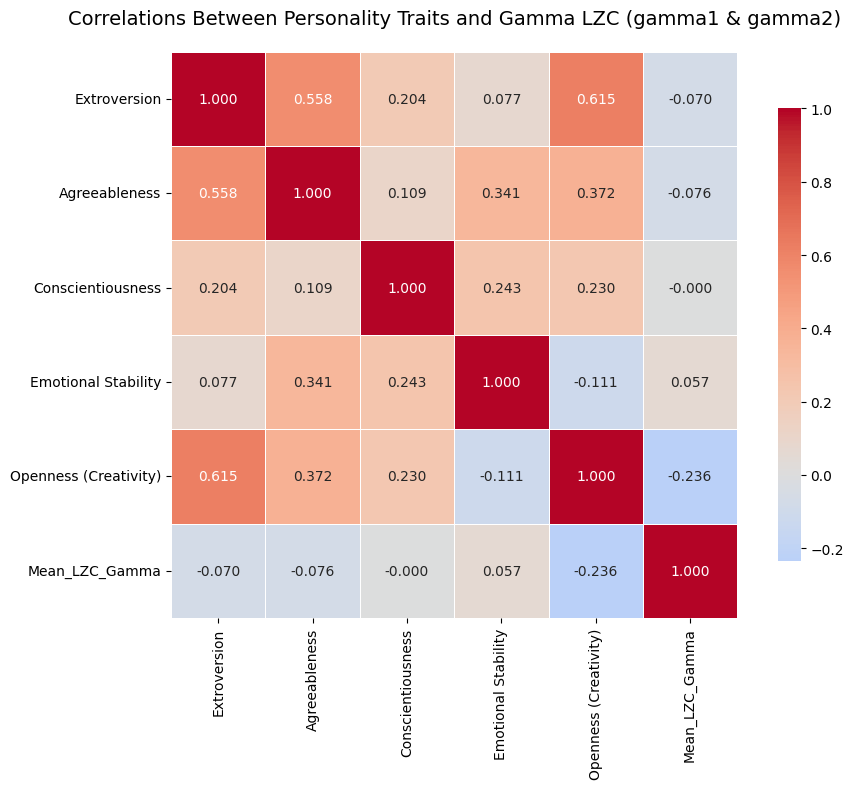

In [364]:
# --------------------------
# 4. Correlation matrix heatmap visualization (Gamma Only)
# --------------------------

# Select only personality traits + LZC for correlation matrix
cols = [
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Emotional Stability",
    "Openness (Creativity)",
    "Mean_LZC_Gamma"
]

trait_gamma_df = merged_gamma_df[cols]

# Compute correlation matrix using Pearson correlation
corr_gamma_matrix = trait_gamma_df.corr(method="pearson")

print("Correlation Matrix (Gamma Only):")
print("=" * 80)
display(corr_gamma_matrix)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_gamma_matrix, annot=True, cmap="coolwarm", center=0, fmt=".3f", 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlations Between Personality Traits and Gamma LZC (gamma1 & gamma2)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


KeyError: 'Subject ID'